<a href="https://colab.research.google.com/github/argyrisker/Diploma-Thesis/blob/main/No_Use_Of_Dummies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##HARD VOTING ENSEMBLE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, ClassifierMixin

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }

    svc_clf = SVC(probability=True)
    random_search = RandomizedSearchCV(
        svc_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    svc_clf = random_search.best_estimator_

    # Define the SVCWrapper class
    class SVCWrapper(BaseEstimator, ClassifierMixin):
        def __init__(self, svc_clf, threshold=0.5):
            self.svc_clf = svc_clf
            self.threshold = threshold

        def fit(self, X, y):
            self.svc_clf.fit(X, y)
            return self

        def predict(self, X):
            proba = self.svc_clf.predict_proba(X)
            return (proba[:, 1] > self.threshold).astype(int)

    # Train and evaluate the voting classifier
    voting_clf = VotingClassifier(estimators=[('svc', SVCWrapper(svc_clf))], voting='hard')
    voting_clf.fit(X_resampled, y_resampled)
    evaluate_model(X_resampled, y_resampled, voting_clf)

    # Calculate AUC ROC for each individual classifier
    classifiers = voting_clf.estimators_
    auc_scores = []
    for clf in classifiers:
        y_pred_proba_clf = cross_val_predict(clf, X_resampled, y_resampled, cv=cv, method='predict_proba')
        fpr, tpr, thresholds = roc_curve(y_resampled, y_pred_proba_clf[:, 1], pos_label=1)
        auc_score_clf = roc_auc_score(y_resampled, y_pred_proba_clf[:, 1], multi_class='ovr')
        auc_scores.append(auc_score_clf)

    # Average AUC ROC scores of individual classifiers
    avg_auc_score = np.mean(auc_scores)
    print('Voting Classifier Average ROC AUC Score:')
    print(avg_auc_score)


______________________________________________________________________

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
from joblib import Memory

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=21)

# Define a caching directory for joblib
cachedir = './cache'
memory = Memory(cachedir, verbose=0)

def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected

def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))

# Feature selection experiments
feature_selectors = [
    RFECV(estimator=SVC(kernel='linear'), step=1, cv=cv, n_jobs=-1)
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }

    svc_clf = SVC(probability=True)
    random_search = RandomizedSearchCV(
        svc_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    svc_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, svc_clf)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
        RFECV(estimator=SVC(kernel='linear'), step=1, cv=cv)
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }

    svc_clf = SVC(probability=True)
    random_search = RandomizedSearchCV(
        svc_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    svc_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, svc_clf)

#SVM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=22),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }

    svc_clf = SVC(probability=True)
    random_search = RandomizedSearchCV(
        svc_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    svc_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, svc_clf)





Best hyperparameters (RandomizedSearchCV - SelectKBest): {'kernel': 'poly', 'gamma': 0.001, 'C': 1}
              precision    recall  f1-score   support

         0.0       0.60      0.74      0.66        53
         1.0       0.57      0.57      0.57        53
         2.0       0.59      0.38      0.46        53
         3.0       0.68      0.77      0.73        53

    accuracy                           0.61       212
   macro avg       0.61      0.61      0.60       212
weighted avg       0.61      0.61      0.60       212

ROC AUC Score:
0.7835825323365374


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }

    svc_clf = SVC(probability=True)
    random_search = RandomizedSearchCV(
        svc_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    svc_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, svc_clf)


Best hyperparameters (RandomizedSearchCV - SelectKBest): {'kernel': 'poly', 'gamma': 0.001, 'C': 1}
              precision    recall  f1-score   support

         0.0       0.60      0.77      0.68        53
         1.0       0.61      0.57      0.59        53
         2.0       0.59      0.42      0.49        53
         3.0       0.71      0.77      0.74        53

    accuracy                           0.63       212
   macro avg       0.63      0.63      0.62       212
weighted avg       0.63      0.63      0.62       212

ROC AUC Score:
0.7906431707606503


#TRY ADDING FEATURE IMPORTANCE

In [ ]:
!pip install matplotlib

Best hyperparameters (RandomizedSearchCV - SelectKBest): {'kernel': 'poly', 'gamma': 0.001, 'C': 1}
              precision    recall  f1-score   support

         0.0       0.60      0.77      0.68        53
         1.0       0.61      0.57      0.59        53
         2.0       0.59      0.42      0.49        53
         3.0       0.71      0.77      0.74        53

    accuracy                           0.63       212
   macro avg       0.63      0.63      0.62       212
weighted avg       0.63      0.63      0.62       212

ROC AUC Score:
0.7899905067046399


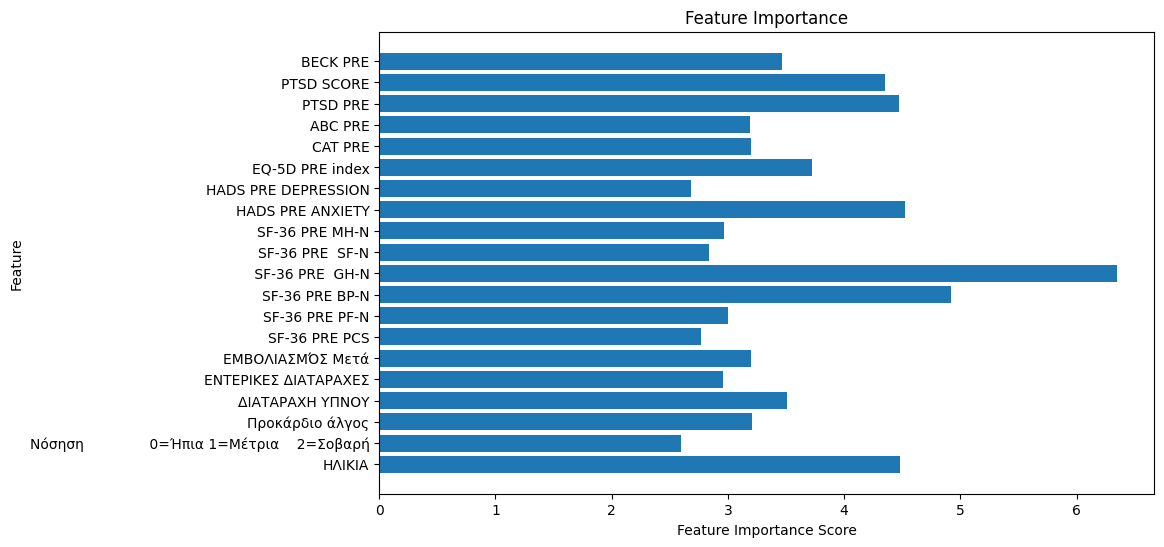

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected, selector


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected, selector = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }

    svc_clf = SVC(probability=True)
    random_search = RandomizedSearchCV(
        svc_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    svc_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, svc_clf)

    # Get feature importances if available
    if hasattr(selector, 'scores_'):
        selected_feature_indices = selector.get_support(indices=True)
        feature_scores = selector.scores_[selected_feature_indices]
        feature_names = X.columns[selected_feature_indices]
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_scores)), feature_scores, tick_label=feature_names)
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Feature')
        plt.title('Feature Importance')
        plt.show()

#RANDOM FOREST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
    SelectKBest(score_func=mutual_info_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [3, 5, 7, 9],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    }

    rf_clf = RandomForestClassifier()
    random_search = RandomizedSearchCV(
        rf_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    rf_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, rf_clf)

    # Recursive Feature Elimination (RFE)
    rfe = RFECV(estimator=rf_clf, cv=cv)
    X_rfe = rfe.fit_transform(X_resampled, y_resampled)

    selected_feature_indices = np.where(rfe.support_)[0]
    selected_features = X.columns[selected_feature_indices]
    print("Selected Features:", selected_features)
    print("Feature Ranking:", rfe.ranking_)

Best hyperparameters (RandomizedSearchCV - SelectKBest): {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 7, 'bootstrap': True}
              precision    recall  f1-score   support

         0.0       0.59      0.62      0.61        53
         1.0       0.38      0.40      0.39        53
         2.0       0.42      0.34      0.37        53
         3.0       0.64      0.70      0.67        53

    accuracy                           0.51       212
   macro avg       0.51      0.51      0.51       212
weighted avg       0.51      0.51      0.51       212

ROC AUC Score:
0.7722795775483565
Selected Features: Index(['ΦΥΛΟ              0= Αρσενικό             1= Θηλυκό',
       'ΝΟΣΗΛΕΙΑ   ΌΧΙ=0                                     ΝΑΙ=1',
       'ΜΕΘ ΌΧΙ=0                                     ΝΑΙ=1',
       'ΔΙΑΣΩΛΗΝΩΣΗ  ΌΧΙ=0                                     ΝΑΙ=1',
       'ΥΨΗΛΑ ΜΕΙΓΜΑΤΑ Ο2(>/=MN40%)', 'ΔΥΣΠΝΟΙΑ ', 'Ρινική Συμφόρηση', 'ΒΗΧΑΣ',
      

##k=30

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=30),
    SelectKBest(score_func=mutual_info_classif, k=30),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [3, 5, 7, 9],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    }

    rf_clf = RandomForestClassifier()
    random_search = RandomizedSearchCV(
        rf_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    rf_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, rf_clf)

    # Recursive Feature Elimination (RFE)
    rfe = RFECV(estimator=rf_clf, cv=cv)
    X_rfe = rfe.fit_transform(X_resampled, y_resampled)

    selected_feature_indices = np.where(rfe.support_)[0]
    selected_features = X.columns[selected_feature_indices]
    print("Selected Features:", selected_features)
    print("Feature Ranking:", rfe.ranking_)


#KNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
    SelectKBest(score_func=mutual_info_classif, k=20),
]

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Create KNN Classifier
    knn_clf = KNeighborsClassifier()

    print(f"Model with {selector.__class__.__name__}:")
    evaluate_model(X_resampled, y_resampled, knn_clf)



##k=45

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# Define feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=45),
    SelectKBest(score_func=mutual_info_classif, k=45),
]

# Initialize SMOTE
smote = SMOTE()

# Perform feature selection and model evaluation
for selector in feature_selectors:
    X_selected = selector.fit_transform(X_imputed, y)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Define the parameter grid for KNN Classifier
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 10, 20, 30, 40, 50],  # Number of neighbors
        'weights': ['uniform', 'distance'],  # Weight function used in prediction
        'metric': ['euclidean', 'manhattan']  # Distance metric
    }

    # GridSearchCV with KNN Classifier
    grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_grid,
                               scoring='accuracy',  # You can change the scoring metric as per your requirement
                               cv=cv,
                               n_jobs=-1)  # Use parallel processing if possible

    # Fit the grid search to the data
    grid_search.fit(X_resampled, y_resampled)

    # Best parameters found
    print("Best Parameters for", selector.__class__.__name__, ":", grid_search.best_params_)

    # Best cross-validation accuracy score
    print("Best Cross-validation Accuracy Score:", grid_search.best_score_)

    # Best estimator
    best_knn_clf = grid_search.best_estimator_

    # Evaluate the best model
    print("Evaluation of the Best Model:")
    y_pred = cross_val_predict(best_knn_clf, X_resampled, y_resampled, cv=cv)
    print(classification_report(y_resampled, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(best_knn_clf, 'predict_proba'):
        y_pred_proba = cross_val_predict(best_knn_clf, X_resampled, y_resampled, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y_resampled, y_pred_proba, multi_class='ovr'))


#DECISION TREES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
    SelectKBest(score_func=mutual_info_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["auto", "sqrt", "log2"],
        "class_weight": [None, "balanced"],
    }

    dt_clf = DecisionTreeClassifier()
    grid_search = GridSearchCV(
        dt_clf, param_grid=param_grid, cv=cv, n_jobs=-1
    )
    grid_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (GridSearchCV - {selector.__class__.__name__}):",
          grid_search.best_params_)

    dt_clf = grid_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, dt_clf)





##try select k

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif),
    SelectKBest(score_func=mutual_info_classif),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

# Define the list of k values to search over
k_values = [10, 12, 15, 20, 22, 25, 30, 32, 35, 40, 42, 45, 50, 52, 55, 60, 62, 65, 70, 72, 75, 80]

for selector in feature_selectors:
    best_score = -1  # Initialize the best score
    best_k = None  # Initialize the best k value

    for k in k_values:
        # Select features using the current k value
        selector.set_params(k=k)
        X_selected = select_and_fit_features(X_imputed, y, selector)

        # Apply SMOTE
        X_resampled, y_resampled = smote.fit_resample(X_selected, y)

        # Hyperparameter tuning with RandomizedSearchCV
        param_dist = {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 10, 20, 30, 40, 50],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt"],  # Set max_features explicitly to 'sqrt'
            "class_weight": [None, "balanced"],
        }

        dt_clf = DecisionTreeClassifier()
        random_search = RandomizedSearchCV(
            dt_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
        )
        random_search.fit(X_resampled, y_resampled)

        # Check if the current score is better than the best score
        if random_search.best_score_ > best_score:
            best_score = random_search.best_score_
            best_k = k

            # Save the best hyperparameters and model
            best_hyperparameters = random_search.best_params_
            best_model = random_search.best_estimator_

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}) for k={best_k}:")
    print(best_hyperparameters)
    evaluate_model(X_resampled, y_resampled, best_model)



#XGBOOST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
    SelectKBest(score_func=mutual_info_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [3, 5, 7, 9],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    }

    xgb_clf = XGBClassifier()
    random_search = RandomizedSearchCV(
        xgb_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    xgb_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, xgb_clf)

    # Recursive Feature Elimination (RFE)
    rfe = RFECV(estimator=xgb_clf, cv=cv)
    X_rfe = rfe.fit_transform(X_resampled, y_resampled)

    selected_feature_indices = np.where(rfe.support_)[0]
    selected_features = X.columns[selected_feature_indices]
    print("Selected Features:", selected_features)
    print("Feature Ranking:", rfe.ranking_)


##k=52

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=52),
    SelectKBest(score_func=mutual_info_classif, k=52),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [3, 5, 7, 9],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    }

    xgb_clf = XGBClassifier()
    random_search = RandomizedSearchCV(
        xgb_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    xgb_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, xgb_clf)

    # Recursive Feature Elimination (RFE)
    rfe = RFECV(estimator=xgb_clf, cv=cv)
    X_rfe = rfe.fit_transform(X_resampled, y_resampled)

    selected_feature_indices = np.where(rfe.support_)[0]
    selected_features = X.columns[selected_feature_indices]
    print("Selected Features:", selected_features)
    print("Feature Ranking:", rfe.ranking_)


#Federated

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

class ClientDataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected

def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))

# Federated Learning
def federated_learning(X_imputed, y, feature_selector):
    global_model = XGBClassifier()  # Global model

    for epoch in range(10):  # Number of federated learning epochs
        for i in range(5):  # Assuming 5 clients
            # Split data into clients
            client_X = X_imputed[i * len(X_imputed) // 5: (i + 1) * len(X_imputed) // 5]
            client_y = y[i * len(y) // 5: (i + 1) * len(y) // 5]
            client_dataset = ClientDataset(client_X, client_y)

            # Feature selection
            X_selected = select_and_fit_features(client_dataset.X, client_dataset.y, feature_selector)

            # Train local model
            local_model = XGBClassifier()
            local_model.fit(X_selected, client_dataset.y)

            # Update global model
            global_model = local_model

    # Evaluation
    for i in range(5):  # Assuming 5 clients
        client_X = X_imputed[i * len(X_imputed) // 5: (i + 1) * len(X_imputed) // 5]
        client_y = y[i * len(y) // 5: (i + 1) * len(y) // 5]
        client_dataset = ClientDataset(client_X, client_y)

        # Feature selection
        X_selected = select_and_fit_features(client_dataset.X, client_dataset.y, feature_selector)

        # Evaluate local model
        evaluate_model(X_selected, client_dataset.y, global_model)

# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=42),
    SelectKBest(score_func=mutual_info_classif, k=42),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    federated_learning(X_imputed, y, selector)


#LSTM

Epoch 1/10
6/6 [==============================] - 6s 360ms/step - loss: 1.4057 - accuracy: 0.1786 - val_loss: 1.3876 - val_accuracy: 0.2188
Epoch 2/10
6/6 [==============================] - 0s 78ms/step - loss: 1.3890 - accuracy: 0.2143 - val_loss: 1.3830 - val_accuracy: 0.3438
Epoch 3/10
6/6 [==============================] - 0s 55ms/step - loss: 1.3782 - accuracy: 0.2381 - val_loss: 1.3881 - val_accuracy: 0.1875
Epoch 4/10
6/6 [==============================] - 0s 50ms/step - loss: 1.3657 - accuracy: 0.3333 - val_loss: 1.3830 - val_accuracy: 0.1875
Epoch 5/10
6/6 [==============================] - 0s 63ms/step - loss: 1.3605 - accuracy: 0.3095 - val_loss: 1.3750 - val_accuracy: 0.1875
Epoch 6/10
6/6 [==============================] - 0s 46ms/step - loss: 1.3540 - accuracy: 0.3214 - val_loss: 1.3887 - val_accuracy: 0.2188
Epoch 7/10
6/6 [==============================] - 0s 61ms/step - loss: 1.3442 - accuracy: 0.3512 - val_loss: 1.4154 - val_accuracy: 0.2500
Epoch 8/10
6/6 [==========

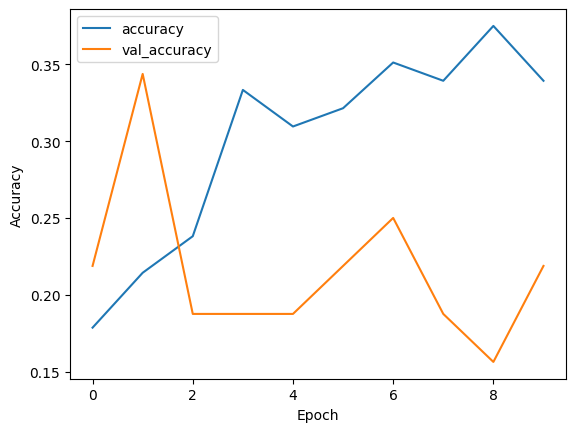

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.2, stratify=y_encoded, random_state=21)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=21)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Reshape input data for LSTM
X_resampled = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM model
model = models.Sequential([
    layers.LSTM(64, input_shape=(X_resampled.shape[1], 1)),
    layers.Dense(4, activation='softmax')  # 3 classes, so 3 output neurons with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for multiclass classification
              metrics=['accuracy'])

# Train the model
history = model.fit(X_resampled, y_resampled, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#CNN

Epoch 1/10
6/6 [==============================] - 4s 232ms/step - loss: 55.2425 - accuracy: 0.2202 - val_loss: 16.4249 - val_accuracy: 0.1562
Epoch 2/10
6/6 [==============================] - 0s 67ms/step - loss: 16.8230 - accuracy: 0.2679 - val_loss: 8.5339 - val_accuracy: 0.2812
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 6.4087 - accuracy: 0.2619 - val_loss: 7.2178 - val_accuracy: 0.1250
Epoch 4/10
6/6 [==============================] - 0s 48ms/step - loss: 3.4993 - accuracy: 0.3214 - val_loss: 6.0021 - val_accuracy: 0.1562
Epoch 5/10
6/6 [==============================] - 0s 47ms/step - loss: 3.1022 - accuracy: 0.3631 - val_loss: 2.5398 - val_accuracy: 0.1562
Epoch 6/10
6/6 [==============================] - 0s 45ms/step - loss: 2.6261 - accuracy: 0.3810 - val_loss: 2.7677 - val_accuracy: 0.2812
Epoch 7/10
6/6 [==============================] - 0s 51ms/step - loss: 1.9225 - accuracy: 0.3571 - val_loss: 1.9732 - val_accuracy: 0.0938
Epoch 8/10
6/6 [=======

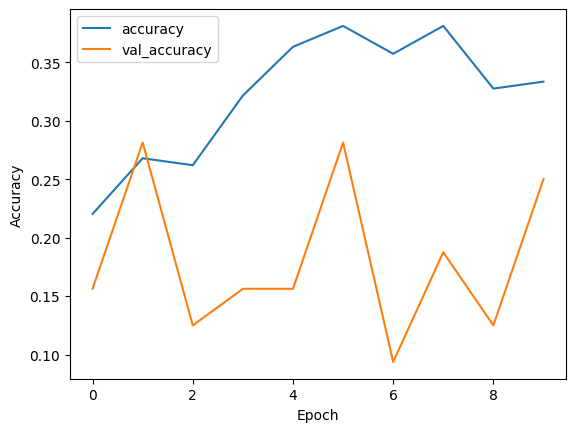

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATASET TO USE1_no45.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.2, stratify=y_encoded, random_state=21)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=21)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Reshape input data for CNN
X_resampled = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_resampled.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(256, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 classes, so 4 output neurons with softmax activation
])


from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)

# Convert class weights to dictionary format
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Compile the model with class weights
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy']) # Pass class weights to the model during training


# Train the model
history = model.fit(X_resampled, y_resampled, epochs=10, validation_data=(X_test, y_test), class_weight=class_weight_dict)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#USE OF CLASSES 0,1,3

##SVM

Best hyperparameters (RandomizedSearchCV - SelectKBest): {'kernel': 'rbf', 'gamma': 0.001, 'C': 1000}
              precision    recall  f1-score   support

           0       0.60      0.59      0.60        49
           1       0.70      0.57      0.63        49
           2       0.69      0.84      0.76        49

    accuracy                           0.67       147
   macro avg       0.67      0.67      0.66       147
weighted avg       0.67      0.67      0.66       147

ROC AUC Score:
0.7763431903373594


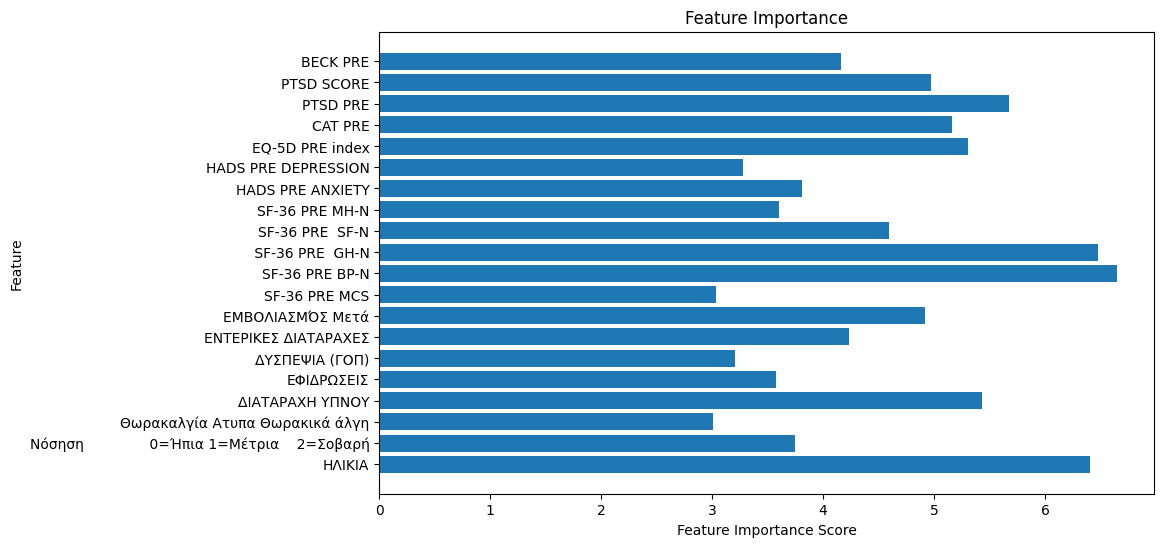

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATANO2.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected, selector


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected, selector = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }

    svc_clf = SVC(probability=True)
    random_search = RandomizedSearchCV(
        svc_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    svc_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, svc_clf)

    # Get feature importances if available
    if hasattr(selector, 'scores_'):
        selected_feature_indices = selector.get_support(indices=True)
        feature_scores = selector.scores_[selected_feature_indices]
        feature_names = X.columns[selected_feature_indices]
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_scores)), feature_scores, tick_label=feature_names)
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Feature')
        plt.title('Feature Importance')
        plt.show()

##DECISION TREES


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATANO2.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
    SelectKBest(score_func=mutual_info_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["auto", "sqrt", "log2"],
        "class_weight": [None, "balanced"],
    }

    dt_clf = DecisionTreeClassifier()
    grid_search = GridSearchCV(
        dt_clf, param_grid=param_grid, cv=cv, n_jobs=-1
    )
    grid_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (GridSearchCV - {selector.__class__.__name__}):",
          grid_search.best_params_)

    dt_clf = grid_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, dt_clf)





Best hyperparameters (GridSearchCV - SelectKBest): {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        49
           1       0.44      0.35      0.39        49
           2       0.53      0.59      0.56        49

    accuracy                           0.50       147
   macro avg       0.50      0.50      0.50       147
weighted avg       0.50      0.50      0.50       147

ROC AUC Score:
0.7213313896987367
Best hyperparameters (GridSearchCV - SelectKBest): {'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.44      0.55      0.49        49
           1       0.55      0.53      0.54        49
           2       0.67      0.53      0.59       

##RANDOM FOREST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATANO2.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
    SelectKBest(score_func=mutual_info_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [3, 5, 7, 9],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    }

    rf_clf = RandomForestClassifier()
    random_search = RandomizedSearchCV(
        rf_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    rf_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, rf_clf)

    # Recursive Feature Elimination (RFE)
    rfe = RFECV(estimator=rf_clf, cv=cv)
    X_rfe = rfe.fit_transform(X_resampled, y_resampled)

    selected_feature_indices = np.where(rfe.support_)[0]
    selected_features = X.columns[selected_feature_indices]
    print("Selected Features:", selected_features)
    print("Feature Ranking:", rfe.ranking_)

Best hyperparameters (RandomizedSearchCV - SelectKBest): {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7, 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.65      0.63      0.64        49
           1       0.63      0.63      0.63        49
           2       0.72      0.73      0.73        49

    accuracy                           0.67       147
   macro avg       0.67      0.67      0.67       147
weighted avg       0.67      0.67      0.67       147

ROC AUC Score:
0.8392336526447313
Selected Features: Index(['ΦΥΛΟ              0= Αρσενικό             1= Θηλυκό',
       'Νόσηση               0=Ήπια 1=Μέτρια    2=Σοβαρή', 'ΑΡΙΘΜΟΣ ΝΟΣΗΣΕΩΝ',
       'ΔΙΑΣΩΛΗΝΩΣΗ  ΌΧΙ=0                                     ΝΑΙ=1',
       'ΥΨΗΛΑ ΜΕΙΓΜΑΤΑ Ο2(>/=MN40%)', 'ΔΥΣΠΝΟΙΑ ', 'Ρινική Συμφόρηση', 'ΒΗΧΑΣ',
       'Θωρακαλγία Ατυπα Θωρακικά άλγη', 'Προκάρδιο άλγος',
       'Συσφιγκτικό άλγος στην προκάρδιαχώρα', 'Αίσθη

##XGBOOST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATANO2.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
    SelectKBest(score_func=mutual_info_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [3, 5, 7, 9],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    }

    xgb_clf = XGBClassifier()
    random_search = RandomizedSearchCV(
        xgb_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    xgb_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, xgb_clf)

    # Recursive Feature Elimination (RFE)
    rfe = RFECV(estimator=xgb_clf, cv=cv)
    X_rfe = rfe.fit_transform(X_resampled, y_resampled)

    selected_feature_indices = np.where(rfe.support_)[0]
    selected_features = X.columns[selected_feature_indices]
    print("Selected Features:", selected_features)
    print("Feature Ranking:", rfe.ranking_)


Best hyperparameters (RandomizedSearchCV - SelectKBest): {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

           0       0.73      0.61      0.67        49
           1       0.66      0.76      0.70        49
           2       0.76      0.78      0.77        49

    accuracy                           0.71       147
   macro avg       0.72      0.71      0.71       147
weighted avg       0.72      0.71      0.71       147

ROC AUC Score:
0.842010273497154
Selected Features: Index(['ΦΥΛΟ              0= Αρσενικό             1= Θηλυκό', 'ΗΛΙΚΙΑ',
       'Νόσηση               0=Ήπια 1=Μέτρια    2=Σοβαρή', 'ΑΡΙΘΜΟΣ ΝΟΣΗΣΕΩΝ',
       'ΝΟΣΗΛΕΙΑ   ΌΧΙ=0                                     ΝΑΙ=1',
       'ΜΕΘ ΌΧΙ=0                                     ΝΑΙ=1',
       'ΔΙΑΣΩΛΗΝΩΣΗ  ΌΧΙ=0                                     ΝΑΙ=1',
       'ΥΨΗΛΑ ΜΕΙΓΜΑΤΑ Ο2(>/=MN40%)', 'ΔΥΣΠΝΟΙΑ ', 'Ρ

##KNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATANO2.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
    SelectKBest(score_func=mutual_info_classif, k=20),
]

for selector in feature_selectors:
    X_selected = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Create KNN Classifier
    knn_clf = KNeighborsClassifier()

    print(f"Model with {selector.__class__.__name__}:")
    evaluate_model(X_resampled, y_resampled, knn_clf)


Model with SelectKBest:
              precision    recall  f1-score   support

           0       0.37      0.51      0.43        49
           1       0.44      0.29      0.35        49
           2       0.51      0.49      0.50        49

    accuracy                           0.43       147
   macro avg       0.44      0.43      0.42       147
weighted avg       0.44      0.43      0.42       147

ROC AUC Score:
0.6859988893516591
Model with SelectKBest:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        49
           1       0.34      0.27      0.30        49
           2       0.47      0.45      0.46        49

    accuracy                           0.46       147
   macro avg       0.45      0.46      0.45       147
weighted avg       0.45      0.46      0.45       147

ROC AUC Score:
0.6261974177426072


##CNN

Epoch 1/10
4/4 [==============================] - 3s 169ms/step - loss: 23.1541 - accuracy: 0.3590 - val_loss: 16.7425 - val_accuracy: 0.3636
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 12.9325 - accuracy: 0.3419 - val_loss: 11.6637 - val_accuracy: 0.2727
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 7.0774 - accuracy: 0.3590 - val_loss: 7.5770 - val_accuracy: 0.3182
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 5.3753 - accuracy: 0.5043 - val_loss: 8.2159 - val_accuracy: 0.3636
Epoch 5/10
4/4 [==============================] - 0s 34ms/step - loss: 4.2264 - accuracy: 0.4188 - val_loss: 7.6026 - val_accuracy: 0.3182
Epoch 6/10
4/4 [==============================] - 0s 36ms/step - loss: 2.4690 - accuracy: 0.5043 - val_loss: 7.0028 - val_accuracy: 0.3636
Epoch 7/10
4/4 [==============================] - 0s 38ms/step - loss: 3.6878 - accuracy: 0.5299 - val_loss: 7.0878 - val_accuracy: 0.2273
Epoch 8/10
4/4 [======

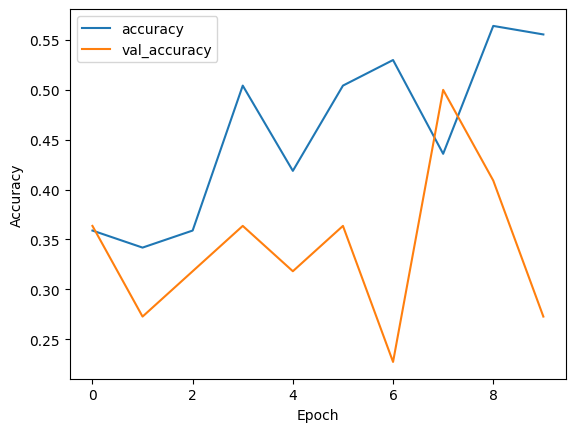

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATANO2.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.2, stratify=y_encoded, random_state=21)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=21)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Reshape input data for CNN
X_resampled = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(X_resampled.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes, so 3 output neurons with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for multiclass classification
              metrics=['accuracy'])

# Train the model
history = model.fit(X_resampled, y_resampled, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##LSTM

Epoch 1/10
4/4 [==============================] - 5s 512ms/step - loss: 1.1263 - accuracy: 0.3162 - val_loss: 1.0758 - val_accuracy: 0.2727
Epoch 2/10
4/4 [==============================] - 0s 76ms/step - loss: 1.0787 - accuracy: 0.3932 - val_loss: 1.1056 - val_accuracy: 0.3636
Epoch 3/10
4/4 [==============================] - 0s 88ms/step - loss: 1.0769 - accuracy: 0.4017 - val_loss: 1.1235 - val_accuracy: 0.3182
Epoch 4/10
4/4 [==============================] - 0s 135ms/step - loss: 1.0601 - accuracy: 0.4274 - val_loss: 1.1033 - val_accuracy: 0.3636
Epoch 5/10
4/4 [==============================] - 0s 105ms/step - loss: 1.0413 - accuracy: 0.5043 - val_loss: 1.0725 - val_accuracy: 0.2727
Epoch 6/10
4/4 [==============================] - 0s 83ms/step - loss: 1.0299 - accuracy: 0.5214 - val_loss: 1.0594 - val_accuracy: 0.2273
Epoch 7/10
4/4 [==============================] - 0s 85ms/step - loss: 1.0256 - accuracy: 0.4786 - val_loss: 1.0614 - val_accuracy: 0.2273
Epoch 8/10
4/4 [========

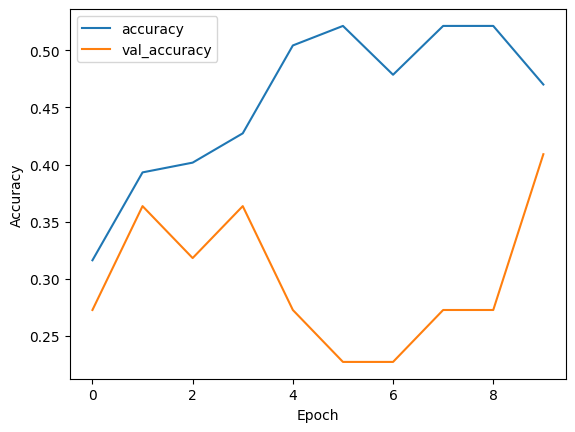

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/DATANO2.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.2, stratify=y_encoded, random_state=21)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=21)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Reshape input data for LSTM
X_resampled = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM model
model = models.Sequential([
    layers.LSTM(64, input_shape=(X_resampled.shape[1], 1)),
    layers.Dense(3, activation='softmax')  # 3 classes, so 3 output neurons with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for multiclass classification
              metrics=['accuracy'])

# Train the model
history = model.fit(X_resampled, y_resampled, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#USE OF BINARY CLASSIFICATION

#SVM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/BINARY.xlsx')

# Specify the column to split on (assuming 'OUTPUT' is the column name)
split_column = 'OUTPUT'

# Specify columns you want to drop
columns_to_drop = ['ΟΝΟΜΑΤΕΠΩΝΥΜΟ']

# Remove empty rows in the 'OUTPUT' column
df = df.dropna(subset=[split_column])

# Split the DataFrame into features and target
X = df.drop(columns=[split_column] + columns_to_drop)
y = df[split_column]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)


def select_and_fit_features(X, y, feature_selector):
    """Selects features and fits the transform"""
    # Create an instance of the selector
    selector = feature_selector
    X_selected = selector.fit_transform(X, y)
    return X_selected, selector


def evaluate_model(X, y, model):
    """Evaluates model performance using cross-validation"""
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred, zero_division=1))

    # Calculate AUC ROC if model provides probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        print('ROC AUC Score:')
        print(roc_auc_score(y, y_pred_proba, multi_class='ovr'))


# Feature selection experiments
feature_selectors = [
    SelectKBest(score_func=f_classif, k=20),
]

# SMOTE for handling class imbalance
smote = SMOTE(random_state=21)

for selector in feature_selectors:
    X_selected, selector = select_and_fit_features(X_imputed, y, selector)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Hyperparameter tuning with RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }

    svc_clf = SVC(probability=True)
    random_search = RandomizedSearchCV(
        svc_clf, param_distributions=param_dist, n_iter=50, cv=cv, random_state=21, n_jobs=-1
    )
    random_search.fit(X_resampled, y_resampled)

    print(f"Best hyperparameters (RandomizedSearchCV - {selector.__class__.__name__}):",
          random_search.best_params_)

    svc_clf = random_search.best_estimator_
    evaluate_model(X_resampled, y_resampled, svc_clf)

    # Get feature importances if available
    if hasattr(selector, 'scores_'):
        selected_feature_indices = selector.get_support(indices=True)
        feature_scores = selector.scores_[selected_feature_indices]
        feature_names = X.columns[selected_feature_indices]
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_scores)), feature_scores, tick_label=feature_names)
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Feature')
        plt.title('Feature Importance')
        plt.show()